In [1]:
# load library
import pandas as pd
import numpy as np
import seaborn as sns
import plotly.express as px
import matplotlib.pyplot as plt
from imblearn.under_sampling import RandomUnderSampler

## EDA

loan status is fully paid status

In [2]:
# import cleaned dataset
accepted_cleaned = pd.read_csv('./cleaned dataset v1.csv')
accepted_cleaned.drop(columns=['Unnamed: 0','sub_grade','addr_state'],inplace=True)
accepted_cleaned.head()

,loan_amnt,term,int_rate,installment,grade,emp_length,home_ownership,annual_inc,verification_status,pymnt_plan,...,num_tl_30dpd,num_tl_90g_dpd_24m,num_tl_op_past_12m,pct_tl_nvr_dlq,percent_bc_gt_75,pub_rec_bankruptcies,tax_liens,total_bal_ex_mort,total_bc_limit,loan_status
0,3600.0,36 months,13.99,123.03,C,10+ years,MORTGAGE,55000.0,Not Verified,n,...,0.0,0.0,3.0,76.9,0.0,0.0,0.0,7746.0,2400.0,1
1,24700.0,36 months,11.99,820.28,C,10+ years,MORTGAGE,65000.0,Not Verified,n,...,0.0,0.0,2.0,97.4,7.7,0.0,0.0,39475.0,79300.0,1
2,20000.0,60 months,10.78,432.66,B,10+ years,MORTGAGE,63000.0,Not Verified,n,...,0.0,0.0,0.0,100.0,50.0,0.0,0.0,18696.0,6200.0,1
3,10400.0,60 months,22.45,289.91,F,3 years,MORTGAGE,104433.0,Source Verified,n,...,0.0,0.0,4.0,96.6,60.0,0.0,0.0,95768.0,20300.0,1
4,11950.0,36 months,13.44,405.18,C,4 years,RENT,34000.0,Source Verified,n,...,0.0,0.0,0.0,100.0,100.0,0.0,0.0,12798.0,9400.0,1


In [3]:
accepted_cleaned.loan_status.value_counts()

1    1076751
0     268559
Name: loan_status, dtype: int64

In [4]:
accepted_cleaned.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1345310 entries, 0 to 1345309
Data columns (total 74 columns):
 #   Column                      Non-Null Count    Dtype  
---  ------                      --------------    -----  
 0   loan_amnt                   1345310 non-null  float64
 1   term                        1345310 non-null  object 
 2   int_rate                    1345310 non-null  float64
 3   installment                 1345310 non-null  float64
 4   grade                       1345310 non-null  object 
 5   emp_length                  1345310 non-null  object 
 6   home_ownership              1345310 non-null  object 
 7   annual_inc                  1345310 non-null  float64
 8   verification_status         1345310 non-null  object 
 9   pymnt_plan                  1345310 non-null  object 
 10  purpose                     1345310 non-null  object 
 11  title                       1345310 non-null  object 
 12  dti                         1345310 non-null  float64
 1

## Feature Engineering

In [5]:
# import package for feature engineering
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import SelectFromModel
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import MinMaxScaler, StandardScaler, OneHotEncoder
import xgboost as xgb

In [6]:
# generate dict for unique values in each column
unique_dict = {}
for col in accepted_cleaned.columns:
    unique_dict[col] = [accepted_cleaned[col].unique()]
# generate data frame for unique values in each column
unique_dict = pd.DataFrame.from_dict(unique_dict, orient='index')
unique_dict['len'] = unique_dict[0].apply(len)

In [7]:
# adjust the import error
accepted_cleaned['term'] = accepted_cleaned['term'].str.strip()
# remove the columns with only 1 value.
accepted_cleaned = accepted_cleaned.drop(columns = ['out_prncp', 'pymnt_plan'])

In [8]:
# split to small datasetss
X, _, y, _= train_test_split(accepted_cleaned.drop(columns='loan_status'), accepted_cleaned['loan_status'], test_size=0.75, random_state=42)
X.shape, y.shape

((336327, 71), (336327,))

In [9]:
# import package for imbalanced data.
#from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler

In [10]:
# Normalization and onehot encode.
X_num_cols = X.select_dtypes(include='number').columns.tolist()
X_cat_cols = X.select_dtypes(include='O').columns.tolist()

In [11]:
len(X_num_cols+X_cat_cols)

71

In [12]:
SD = StandardScaler()
OE = OneHotEncoder(drop='first')
X_num = SD.fit_transform(X[X_num_cols])
X_cat = OE.fit_transform(X[X_cat_cols])
X_cat = X_cat.toarray()

In [13]:
X_num.shape, X_cat.shape

((336327, 62), (336327, 48))

In [14]:
# combine feature names and matrix names
feature_names = np.concatenate((SD.get_feature_names_out(), OE.get_feature_names_out()))
X = np.concatenate((X_num, X_cat), axis = 1)
print(X.shape, y.shape)

(336327, 110) (336327,)


In [15]:
# undersampling
us = RandomUnderSampler()
X, y = us.fit_resample(X, y)
X.shape, y.shape

((134596, 110), (134596,))

### Method 1: dot product of important features

In [16]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier

In [17]:
# Random forest feature importance
FI_RF = RandomForestClassifier()
FI_RF.fit(X, y)
FI_RF_importances = FI_RF.feature_importances_

In [18]:
# Logistic Regression coefficient (not suitable for data with multilinearity)
FI_LR  = LogisticRegression()
FI_LR.fit(X, y)
FI_LR_importances = FI_LR.coef_[0]

/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [19]:
# Decision Tree
FI_tree = DecisionTreeClassifier()
FI_tree.fit(X, y)
FI_tree_importance = FI_tree.feature_importances_

In [20]:
# XGboost
FI_XGboost = XGBClassifier()
FI_XGboost.fit(X, y)
FI_XGboost_importance = FI_XGboost.feature_importances_

/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[22:20:28] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


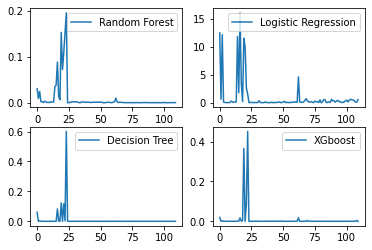

In [21]:
plt.subplot(2,2,1); plt.plot(FI_RF.feature_importances_, label='Random Forest')
plt.legend()
plt.subplot(2,2,2); plt.plot(np.abs(FI_LR.coef_[0]), label = 'Logistic Regression')
plt.legend()
plt.subplot(2,2,3); plt.plot(FI_tree.feature_importances_, label = 'Decision Tree')
plt.legend()
plt.subplot(2,2,4); plt.plot(FI_XGboost.feature_importances_, label = 'XGboost')
plt.legend()
plt.show()

In [22]:
def importance_colIdx(model,label=''):
    try:
        idx = np.argsort(model.feature_importances_)[::-1] # largest to smallest
        plt.plot(range(len(idx)), model.feature_importances_[idx],label=label)
    except:
        idx = np.argsort(np.abs(model.coef_[0]))[::-1] # largest to smallest
        plt.plot(range(len(idx)), abs(model.coef_[0])[idx], label=label)
    plt.legend()
    plt.xticks(range(len(idx)),labels=idx, rotation=90)
    return idx

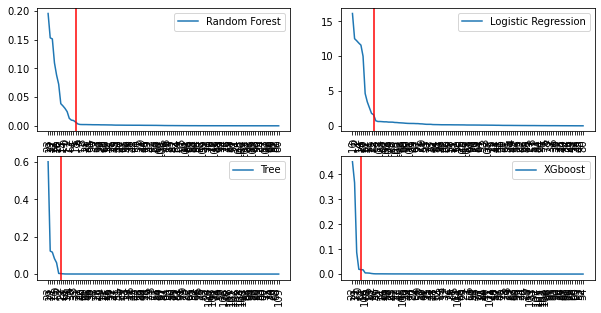

In [23]:
# plot and save all method 1 values
plt.figure(figsize=(10,5))
plt.subplot(2,2,1); method_1_rf_features = feature_names[importance_colIdx(FI_RF,'Random Forest')[:13]]; plt.axvline(x=13, c='r')
plt.subplot(2,2,2); method_1_lr_features = feature_names[importance_colIdx(FI_LR, 'Logistic Regression')[:10]];plt.axvline(x=10, c='r')
plt.subplot(2,2,3); method_1_tree_features = feature_names[importance_colIdx(FI_tree, 'Tree')[:6]];plt.axvline(x=6, c='r')
plt.subplot(2,2,4); method_1_xgb_features = feature_names[importance_colIdx(FI_XGboost, 'XGboost')[:4]];plt.axvline(x=4, c='r')
plt.legend()
plt.show()

In [24]:
# sum up all the important features
minmax = MinMaxScaler()
selected_features= np.abs( \
    minmax.fit_transform(FI_RF_importances.reshape(-1,1)) + \
    minmax.fit_transform(FI_LR_importances.reshape(-1,1)) + \
    minmax.fit_transform(FI_tree_importance.reshape(-1,1)) + \
    minmax.fit_transform(FI_XGboost_importance.reshape(-1,1)))

In [25]:
fig = px.line(selected_features)
fig.update_layout(
    margin=dict(l=10, r=5, t=5, b=10))
fig.show()

In [26]:
# select value with feature importance larger than 0.5
sorted(selected_features, reverse=True)[:10] # select [:9]

[array([2.4384387]),
 array([2.2701664]),
 array([1.8326428]),
 array([1.62843392]),
 array([1.47687838]),
 array([1.0315744]),
 array([0.69823815]),
 array([0.50651612]),
 array([0.47353394]),
 array([0.46272485])]

In [27]:
# print the column name according to the feature names
#sum(selected_features>0.001)
selected_idx = np.squeeze(np.argsort(selected_features, axis=0)[::-1]) # from largest to lowest
columns = feature_names[selected_idx] # from largest to lowest
print(columns)

['last_fico_range_low' 'last_fico_range_high' 'recoveries'
 'total_rec_prncp' 'last_pymnt_amnt' 'total_pymnt' 'total_pymnt_inv'
 'int_rate' 'total_rec_late_fee' 'grade_G' 'collection_recovery_fee'
 'fico_range_low' 'annual_inc' 'title_consolidation' 'num_sats'
 'revol_util' 'total_bal_ex_mort' 'total_bc_limit' 'total_rev_hi_lim'
 'total_acc' 'dti' 'fico_range_high' 'initial_list_status_w'
 'acc_open_past_24mths' 'bc_util' 'grade_E' 'tot_cur_bal' 'revol_bal'
 'avg_cur_bal' 'mo_sin_old_il_acct' 'num_actv_rev_tl'
 'pub_rec_bankruptcies' 'purpose_renewable_energy' 'mths_since_recent_bc'
 'num_bc_sats' 'num_tl_op_past_12m' 'mo_sin_old_rev_tl_op' 'num_rev_accts'
 'grade_B' 'mo_sin_rcnt_tl' 'home_ownership_OTHER' 'num_op_rev_tl'
 'num_actv_bc_tl' 'mo_sin_rcnt_rev_tl_op' 'mort_acc' 'pct_tl_nvr_dlq'
 'tax_liens' 'grade_D' 'purpose_vacation' 'title_wedding'
 'emp_length_5 years' 'num_bc_tl' 'purpose_major_purchase' 'tot_coll_amt'
 'percent_bc_gt_75' 'mths_since_recent_inq' 'num_accts_ever_120_pd

[23 22 19 16 21 14 15  1 18] ['last_fico_range_low' 'last_fico_range_high' 'recoveries'
 'total_rec_prncp' 'last_pymnt_amnt' 'total_pymnt' 'total_pymnt_inv'
 'int_rate' 'total_rec_late_fee']


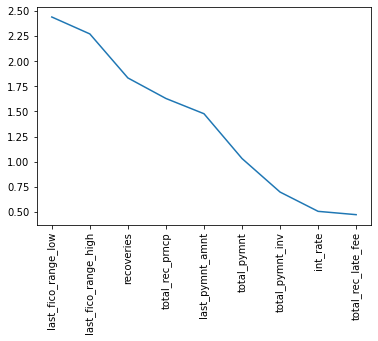

In [28]:
# create selected cols
selected_cols_idx = selected_idx[:9]
selected_cols_name = columns[:9]
print(selected_cols_idx, selected_cols_name)

plt.plot(range(9),selected_features[selected_cols_idx])
plt.xticks(ticks = range(9), labels = selected_cols_name, rotation = 90)
plt.show()

In [29]:
# selected features by method 1
method_1_features = selected_cols_name

### method 2 Partial dependence plots and SHapley Additive exPlanations (SHAP)
https://shap.readthedocs.io/en/latest/example_notebooks/tabular_examples/tree_based_models/Python%20Version%20of%20Tree%20SHAP.html


SHAP (SHapley Additive exPlanations) is a game theoretic approach to explain the output of any machine learning model. It connects optimal credit allocation with local explanations using the classic Shapley values from game theory and their related extensions (see papers for details and citations).

However, in this article, we discuss how using predictive models to guide this kind of policy choice can often be misleading.

The reason relates to the fundamental difference between correlation and causation. SHAP makes transparent the correlations picked up by predictive ML models. But making correlations transparent does not make them causal! All predictive models implicitly assume that everyone will keep behaving the same way in the future, and therefore correlation patterns will stay constant. To understand what happens if someone starts behaving differently, we need to build causal models, which requires making assumptions and using the tools of causal analysis.

The goal of SHAP is to explain the prediction of an instance x by computing the contribution of each feature to the prediction. Here, we would use 90% as cut-off.

In [30]:
import shap

In [31]:
# select only n rows to limit test time
np.random.seed(seed=42)
rows = np.random.randint(0,134596,100)

In [32]:
# Shap waterfall plot
def make_shap_waterfall_plot(shap_values, features, num_display=20):
    column_list = features.columns
    feature_ratio = (np.abs(shap_values).sum(0) / np.abs(shap_values).sum()) * 100
    column_list = column_list[np.argsort(feature_ratio)[::-1]]
    feature_ratio_order = np.sort(feature_ratio)[::-1]
    cum_sum = np.cumsum(feature_ratio_order)
    column_list = column_list[:num_display]
    feature_ratio_order = feature_ratio_order[:num_display]
    cum_sum = cum_sum[:num_display]
    
    num_height = 0
    if (num_display >= 20) & (len(column_list) >= 20):
        num_height = (len(column_list) - 20) * 0.4
        
    fig, ax1 = plt.subplots(figsize=(8, 8 + num_height))
    ax1.plot(cum_sum[::-1], column_list[::-1], c='blue', marker='o')
    ax2 = ax1.twiny()
    ax2.barh(column_list[::-1], feature_ratio_order[::-1], alpha=0.6)
    
    ax1.grid(True)
    ax2.grid(False)
    ax1.set_xticks(np.arange(0, round(cum_sum.max(), -1)+1, 10))
    ax2.set_xticks(np.arange(0, round(feature_ratio_order.max(), -1)+1, 10))
    ax1.set_xlabel('Cumulative Ratio')
    ax2.set_xlabel('Composition Ratio')
    ax1.tick_params(axis="y", labelsize=13)
    plt.ylim(-1, len(column_list))

    return column_list, cum_sum, feature_ratio_order

#### Random Forest

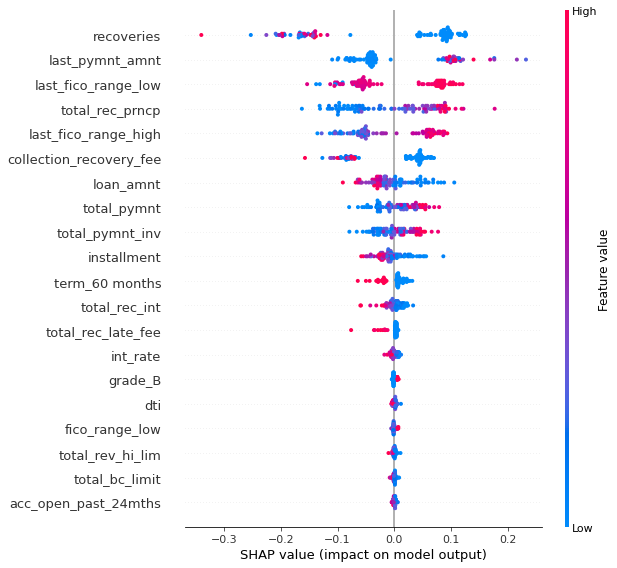

In [33]:
shap.initjs()

# Explain model predictions using shap library:
explainer = shap.TreeExplainer(FI_RF) # must use trained model.
shap_values = explainer.shap_values(X[rows,:])

# Plot summary_plot
shap.summary_plot(shap_values[1],X[rows,:], feature_names=feature_names)

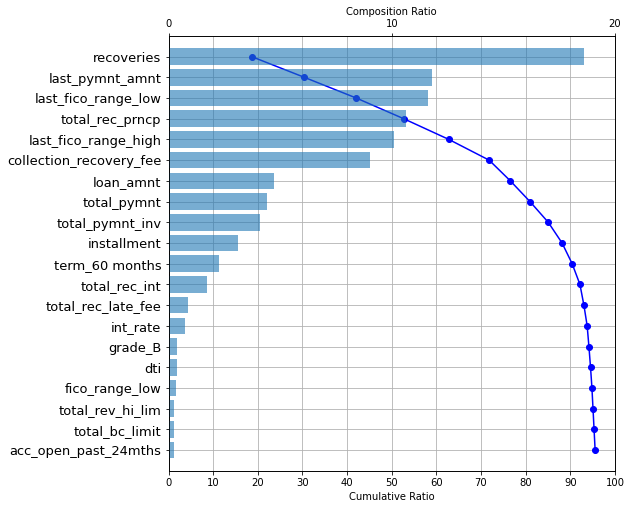

In [34]:
column_list, cum_sum, feature_ratio_order= make_shap_waterfall_plot(shap_values[1], pd.DataFrame(X[rows,:], columns=feature_names))


In [35]:
# vriance explained: features
method_2_rf_features = {cum_sum[cum_sum>=90][0]:column_list[:np.where(cum_sum>=90)[0][0]+1]}

#### tree

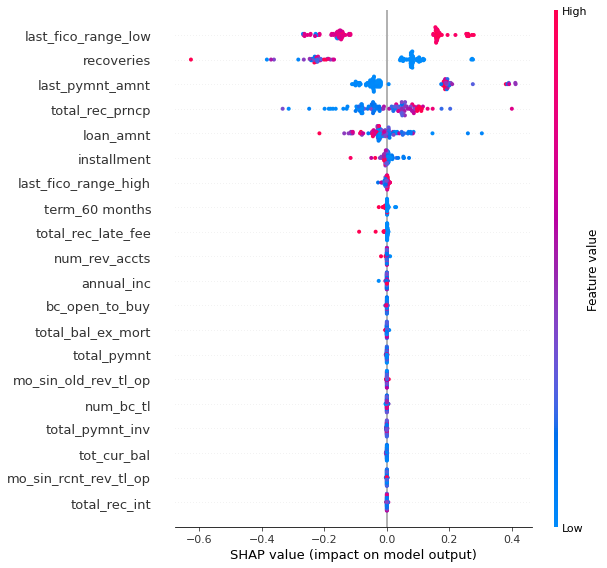

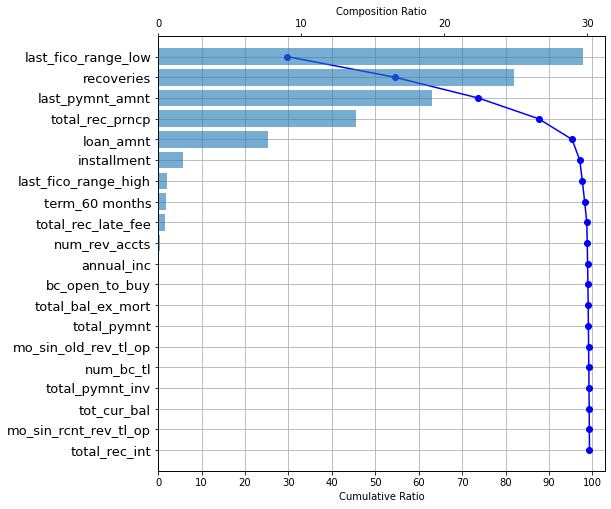

In [36]:
shap.initjs()
# Explain model predictions using shap library:
explainer = shap.TreeExplainer(FI_tree) # must use trained model.
shap_values = explainer.shap_values(X[rows,:])
# Plot summary_plot
shap.summary_plot(shap_values[1],X[rows,:], feature_names=feature_names)
tree_column_list, tree_cum_sum, _ = make_shap_waterfall_plot(shap_values[1], pd.DataFrame(X[rows,:], columns=feature_names))


In [37]:
method_2_tree_features = {tree_cum_sum[9]:tree_column_list[:10]}

#### XGB

ntree_limit is deprecated, use `iteration_range` or model slicing instead.


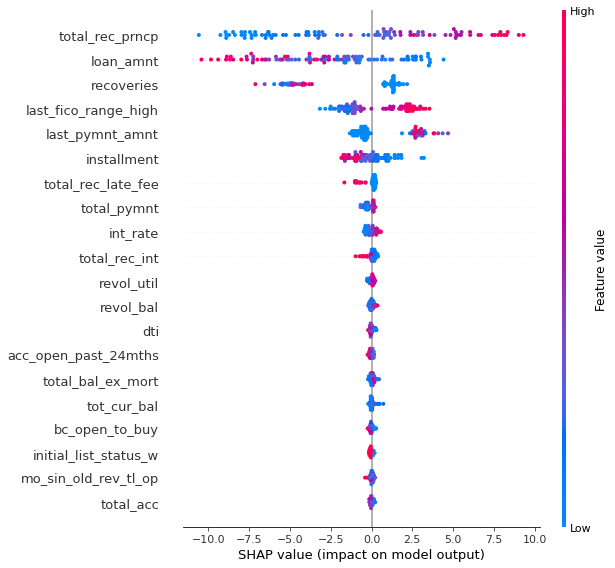

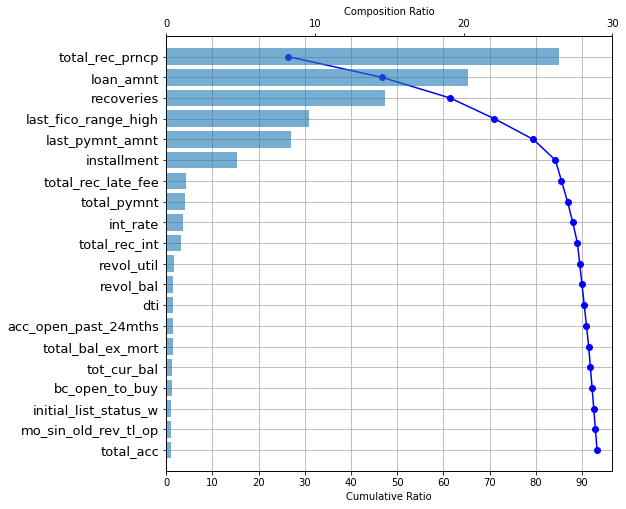

In [38]:
shap.initjs()
# Explain model predictions using shap library:
explainer = shap.TreeExplainer(FI_XGboost) # must use trained model.
shap_values = explainer.shap_values(X[rows,:])
# Plot summary_plot
shap.summary_plot(shap_values, X[rows,:], feature_names=feature_names)
xgb_column_list, xgb_cum_sum, _ = make_shap_waterfall_plot(shap_values, pd.DataFrame(X[rows,:], columns=feature_names))


In [39]:
method_2_xgb_features = {xgb_cum_sum[9]:xgb_column_list[:10]}

#### Logistic Regression

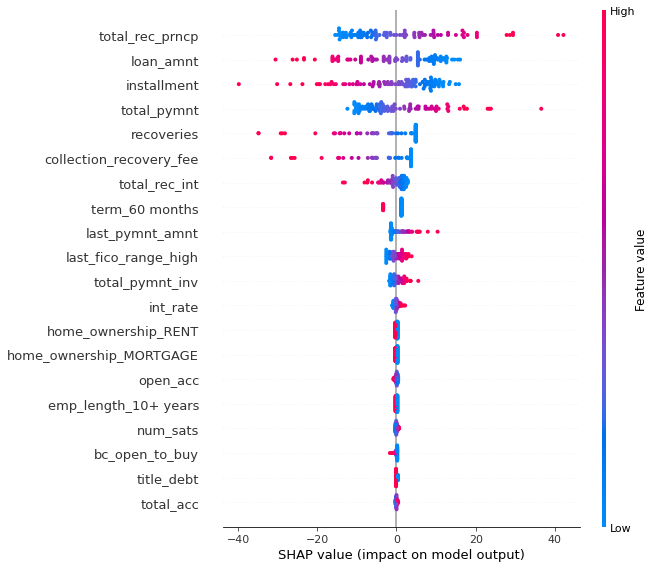

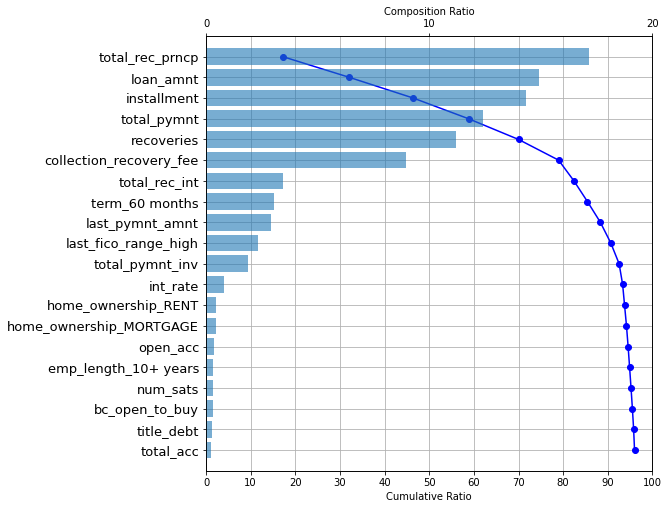

In [40]:
shap.initjs()
# Explain model predictions using shap library:
explainer = shap.Explainer(FI_LR, X[rows,:],feature_names=feature_names ) # must use trained model.
shap_values = explainer.shap_values(X[rows,:])
# Plot summary_plot
shap.summary_plot(shap_values, X[rows,:], feature_names=feature_names)
log_column_list, log_cum_sum, _ = make_shap_waterfall_plot(shap_values, pd.DataFrame(X[rows,:], columns=feature_names))

In [41]:
method_2_log_features = {log_cum_sum[9]:log_column_list[:10]}

### Method 3 Variance Inflation Factor (VIF)

When some features are highly correlated, we might have difficulty in distinguishing between their individual effects on the dependent variable. In VIF method, we pick each feature and regress it against all of the other features. For each regression, the factor is calculated as :

VIF = 1/(1-R^2)

greater the value of R-squared, greater is the VIF. Hence, greater VIF denotes greater correlation. This is in agreement with the fact that a higher R-squared value denotes a stronger collinearity. Generally, a VIF above 5 indicates a high multicollinearity. 

https://stackoverflow.com/questions/42658379/variance-inflation-factor-in-python


In [42]:
cc = np.corrcoef(X, rowvar=False)
VIF = np.linalg.inv(cc)
VIF.diagonal()

array([5.99559397e+01, 1.29815758e+01, 5.05614940e+01, 1.41708834e+00,
       1.26733071e+00, 2.29262719e+00, 7.58520259e+06, 7.58517052e+06,
       1.54138340e+00, 5.16053215e+01, 8.25563397e+00, 5.65797866e+00,
       4.09432813e+00, 3.49108971e+01, 2.80339983e+13, 1.08534102e+03,
       2.09436599e+13, 2.08533143e+12, 5.38458294e+07, 6.30413045e+11,
       1.59348080e+01, 2.98029089e+00, 3.71713740e+00, 2.64527732e+00,
       1.02915190e+00, 4.90076849e+00, 1.00236983e+00, 7.47422315e+00,
       4.84408640e+00, 3.00778980e+00, 5.65739490e+00, 8.51421646e+00,
       6.25911330e+00, 1.05409652e+00, 1.14232089e+00, 1.26064590e+00,
       1.45447310e+00, 2.26028851e+00, 1.84966235e+00, 2.58753139e+00,
       1.68577236e+00, 1.42827955e+00, 1.77996753e+00, 8.26390825e+00,
       3.46901307e+01, 7.86999686e+00, 8.10251052e+00, 1.43917579e+01,
       1.35513823e+01, 2.50489733e+01, 3.64017654e+01, 5.37094152e+01,
       1.88149470e+00, 4.09287489e+00, 2.01513860e+00, 2.67091418e+00,
      

In [43]:
VIF_feature_imp = np.argsort(VIF.diagonal())[::-1]
method_3_features = feature_names[VIF_feature_imp][:10]

### Method 4 Boruta

Boruta is an all **relevant feature selection method**, while most other are minimal optimal; this means it tries to find all features carrying information usable for prediction, rather than finding a possibly compact subset of features on which some classifier has a minimal error.

Why bother with all relevant feature selection? When you try to understand the phenomenon that made your data, you should care about all factors that contribute to it, not just the bluntest signs of it in context of your methodology (yes, minimal optimal set of features by definition depends on your classifier choice).

In [44]:
from boruta import BorutaPy

#### Random Forest

In [45]:
boruta_clf_rf = RandomForestClassifier()
trans_rf = BorutaPy(boruta_clf_rf, random_state=42, verbose=2)
trans_rf.fit(X[rows,:], np.array(y)[rows])
method_4_rf_features= feature_names[trans_rf.support_]

Iteration: 	1 / 100
Confirmed: 	0
Tentative: 	110
Rejected: 	0
Iteration: 	2 / 100
Confirmed: 	0
Tentative: 	110
Rejected: 	0
Iteration: 	3 / 100
Confirmed: 	0
Tentative: 	110
Rejected: 	0
Iteration: 	4 / 100
Confirmed: 	0
Tentative: 	110
Rejected: 	0
Iteration: 	5 / 100
Confirmed: 	0
Tentative: 	110
Rejected: 	0
Iteration: 	6 / 100
Confirmed: 	0
Tentative: 	110
Rejected: 	0
Iteration: 	7 / 100
Confirmed: 	0
Tentative: 	110
Rejected: 	0
Iteration: 	8 / 100
Confirmed: 	0
Tentative: 	10
Rejected: 	100
Iteration: 	9 / 100
Confirmed: 	8
Tentative: 	2
Rejected: 	100
Iteration: 	10 / 100
Confirmed: 	8
Tentative: 	2
Rejected: 	100
Iteration: 	11 / 100
Confirmed: 	8
Tentative: 	2
Rejected: 	100
Iteration: 	12 / 100
Confirmed: 	8
Tentative: 	2
Rejected: 	100
Iteration: 	13 / 100
Confirmed: 	8
Tentative: 	2
Rejected: 	100
Iteration: 	14 / 100
Confirmed: 	8
Tentative: 	2
Rejected: 	100
Iteration: 	15 / 100
Confirmed: 	8
Tentative: 	2
Rejected: 	100
Iteration: 	16 / 100
Confirmed: 	9
Tentative: 	1

#### XGB

In [46]:
boruta_clf_XGB = XGBClassifier()
trans_XGB = BorutaPy(boruta_clf_XGB, random_state=42, verbose=2)
trans_XGB.fit(X[rows,:], np.array(y)[rows])
method_4_xgb_features= feature_names[trans_XGB.support_]

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].


[22:23:07] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Iteration: 	1 / 100
Confirmed: 	0
Tentative: 	110
Rejected: 	0
[22:23:07] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Iteration: 	2 / 100
Confirmed: 	0
Tentative: 	110
Rejected: 	0
[22:23:07] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Iteration: 	3 / 100
Confirmed: 	0
Tentative: 	110
Rejected: 	0
[22:23:08] WARNING: ../src/learner.cc:1115: Starting in

#### tree 

Invalid parameter n_estimators for estimator DecisionTreeClassifier()

#### Logistic Regression

Invalid parameter n_estimators for estimator LogisticRegression()

### Summary

In [47]:
# Method 1: use feature importance, sum all and select the ones with importance larger than 0.5
# Method 2: Use shap of 4 different methods
# Method 3: VIF
# Method 4: Boruta with two methods


In [48]:
def Index2List(test):
    return list(test)[0].tolist()

In [49]:
frame=[]
frame.append(pd.DataFrame(['method 1 rf',method_1_rf_features,0]))
frame.append(pd.DataFrame(['method 1 lr',method_1_lr_features,0]))
frame.append(pd.DataFrame(['method 1 xgb',method_1_xgb_features,0]))
frame.append(pd.DataFrame(['method 1 tree',method_1_tree_features,0]))

frame.append(pd.DataFrame(['method 1',method_1_features,0]))
frame.append(pd.DataFrame(['method 2 rf',Index2List(method_2_rf_features.values()),method_2_rf_features.keys()]))
frame.append(pd.DataFrame(['method 2 log',Index2List(method_2_log_features.values()),method_2_log_features.keys()]))
frame.append(pd.DataFrame(['method 2 xgb',Index2List(method_2_xgb_features.values()),method_2_xgb_features.keys()]))
frame.append(pd.DataFrame(['method 2 tree',Index2List(method_2_tree_features.values()),method_2_tree_features.keys()]))
frame.append(pd.DataFrame(['method 3',method_3_features,0]))
frame.append(pd.DataFrame(['method 4 rf',method_4_rf_features,0]))
frame.append(pd.DataFrame(['method 4 xgb',method_4_xgb_features,0]))

feature_df = pd.concat(frame, axis=1)

In [50]:
feature_df = feature_df.T.reset_index(drop=True)
feature_df.columns = ['method', 'selected', 'variation explained']

In [51]:
feature_df

,method,selected,variation explained
0,method 1 rf,"[last_fico_range_low, recoveries, last_fico_ra...",0
1,method 1 lr,"[total_rec_prncp, loan_amnt, installment, tota...",0
2,method 1 xgb,"[last_fico_range_high, recoveries, last_pymnt_...",0
3,method 1 tree,"[last_fico_range_low, recoveries, last_pymnt_a...",0
4,method 1,"[last_fico_range_low, last_fico_range_high, re...",0
5,method 2 rf,"[recoveries, last_pymnt_amnt, last_fico_range_...",(90.40685554082525)
6,method 2 log,"[total_rec_prncp, loan_amnt, installment, tota...",(90.65964505358221)
7,method 2 xgb,"[total_rec_prncp, loan_amnt, recoveries, last_...",(88.99648)
8,method 2 tree,"[last_fico_range_low, recoveries, last_pymnt_a...",(98.81422208954857)
9,method 3,"[total_pymnt, total_rec_prncp, total_rec_int, ...",0


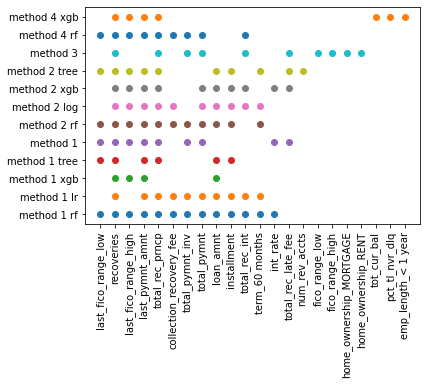

In [52]:
for idx in feature_df.index:
    plt.scatter(feature_df.loc[idx,'selected'], 
    np.ones((len(feature_df.loc[idx,'selected']),1))*idx)
plt.xticks(rotation = 90)
plt.yticks(range(12), labels = feature_df['method'])
plt.show()

In [53]:
feature_df.to_csv('selected_features.csv')